In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import datasets

from utils import *

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

path.ls()

[PosixPath('/home/quantran/.fastai/data/imagenette-160/train'),
 PosixPath('/home/quantran/.fastai/data/imagenette-160/val')]

In [4]:
_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)
norm_imagenette._order = 999

In [5]:
denorm_imagenette = partial(denorm_chan, mean=_m.cuda(), std=_s.cuda())

# Building Dataset

In [6]:
def compose2(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

class AEDataset(ListContainer):
    def __init__(self, items, tfms=[], labelers=[]):
        '''
        items: list of PosixPath
        '''
        super().__init__(items)
        self.tfms, self.labeler = tfms, labelers

    def _get(self,fn):
        return compose2(PIL.Image.open(fn),self.tfms)
    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        res = [self._get(o) for o in items] if isinstance(items,Iterable) else self._get(items)
        
        return res,res

def create_databunch(train_ds, valid_ds, bs, **kwargs):
    return DataBunch(
            DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs)
    )

In [7]:
def get_databunch(tfms=None,bs=64,size=128):
    il = (ImageList.from_folder(path)
     .split_by_folder(valid='val'))
    
    if tfms is None: tfms = [make_rgb, CenterCrop(size),PilRandomFlip(),np_to_float,norm_imagenette]
    val_tfms = [make_rgb, CenterCrop(size), np_to_float,norm_imagenette]
    
    train_ds = AEDataset(il.train.items,tfms)
    val_ds = AEDataset(il.valid.items,val_tfms)
    return create_databunch(train_ds,val_ds,bs)

In [8]:
size = 128
# tfms = [make_rgb, RandomResizedCrop(size, scale=(0.5,1)), PilRandomFlip(),np_to_float,norm_imagenette]
tfms = [make_rgb, CenterCrop(size),PilRandomFlip(),np_to_float,norm_imagenette]
val_tfms = [make_rgb, CenterCrop(size), np_to_float,norm_imagenette]

In [9]:
bs=64

In [10]:
db = get_databunch(tfms,bs,size)

# Hooks for visualization

In [11]:
from collections import defaultdict
from fastai.callbacks.hooks import *

hooks_means = defaultdict(list)
hooks_stds = defaultdict(list)
hooks_hists = defaultdict(list)

# means,stds,hists = [],[],[]
def append_stats(mod, inp, outp):
    if mod.training:
        hooks_means[str(mod)].append(outp.data.mean().cpu())
        hooks_stds[str(mod)].append(outp.data.std().cpu())
        hooks_hists[str(mod)].append(outp.data.cpu().histc(40,-7,7))

In [12]:
def plot_mean_std(hook_layers,ite):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    for m in hook_layers:
        ms,ss = hooks_means[str(m)],hooks_stds[str(m)]
        ax0.plot(ms[:ite])
        ax1.plot(ss[:ite])
    plt.legend(range(len(hook_layers)));

In [13]:
def get_hist(h): return torch.stack(h).t().float().log1p() # Return matrix (# bins, # iterations)
def plot_hist(hook_layers):
    fig,axes = plt.subplots((len(hook_layers)+1)//2,2, figsize=(10,10))
    for ax,m in zip(axes.flatten(), hook_layers):
        ax.imshow(get_hist(hooks_hists[str(m)])[:,:80], origin='lower')
        ax.axis('on')
    plt.tight_layout()

In [14]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[19:22].sum(0)/h1.sum(0) # bin 19,20 and 21 are the middle, where ~0 values stay

def plot_zero(hook_layers):
    fig,axes = plt.subplots((len(hook_layers)+1)//2,2, figsize=(15,6))
    for ax,m in zip(axes.flatten(), hook_layers):
        ax.plot(get_min(hooks_hists[str(m)]))
        ax.set_ylim(0,1)
    plt.tight_layout()

# Model

In [16]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None): # we can now add leaky portion/ subtraction/ max RELU value to clip
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [17]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [18]:
# def de_conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
#     layers = [nn.ConvTranspose2d(nf, ni, ks, padding=ks//2, stride=stride, bias=not bn),
#               GeneralRelu(**kwargs)]
#     if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
#     return nn.Sequential(*layers)

In [19]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [20]:
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x)) # next largest number that is a power of 2

def get_cnn_layers(nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs) # fixed 3x3 conv2d kernels. See above for explanation
    
    l1 = 3
    l2 = prev_pow_2(l1*3*3)
    
    layers =  [f(l1  , l2  , stride=1), # 3x3x3 (27) to 16. First conv2d maintains size (stride 1)
               # by decreasing channels, we prevent model to generate more information than it can
               # we can condense the information/pick out only interesting information to output
               f(l2  , l2*2, stride=2), # 3x3x16 (144) to 32
               f(l2*2, l2*4, stride=2)] # 3x3x32 (288) to 64
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveMaxPool2d(1), Lambda(flatten)]
    return layers

In [55]:
def deconv_layer(ni, nf, ks=3, stride=1,scale_factor=2,bn=True, **kwargs):
    layers = [nn.Upsample(scale_factor=scale_factor,mode='nearest'),
              nn.Conv2d(ni, nf, ks, padding=1, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [66]:
def get_cnn_decoder_layers(nfs, layer, **kwargs):
    def f(ni, nf, stride=1,scale_factor=2): return layer(ni, nf, 3, stride=stride, 
                                                         scale_factor = scale_factor,
                                                         **kwargs) # fixed 3x3 conv2d kernels. See above for explanation
    
    nfs = [16,32,64] + nfs
    layers = [f(nfs[i],nfs[i-1]) for i in range(len(nfs)-1,0,-1)]
    
    layers.append(f(nfs[0],3,scale_factor=1)) # last conv maintain size

    return layers

In [67]:
nfs = [128,256,512]

In [74]:
class ConvAutoEncoderModel(nn.Module):
    def __init__(self,nfs,sz_b4_pool=4,**kwargs):
        super().__init__()
        self.encoder = nn.Sequential(*get_cnn_layers(nfs,conv_layer,**kwargs))
        self.decoder = nn.Sequential(*get_cnn_decoder_layers(nfs,deconv_layer,**kwargs))
        self.sz_b4_pool = sz_b4_pool
    def forward(self, x):
        x = self.encoder(x)
        x = F.interpolate(x[...,None,None],scale_factor=self.sz_b4_pool, mode='nearest')
        x = self.decoder(x)
        x = torch.tanh(x)
        return x

In [75]:
def model_summary(model,layers,xb,print_mod=False):
    f = lambda mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(layers, f) as hooks: model(xb)

In [76]:
conv_model = ConvAutoEncoderModel(nfs).cuda()

In [77]:
all_layers = list(list(conv_model.children())[0]) + list(list(conv_model.children())[1])

In [78]:
xb,_ = next(iter(db.train_dl))

In [79]:
model_summary(conv_model,all_layers,xb,True)

====
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 torch.Size([64, 16, 128, 128])
====
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 torch.Size([64, 32, 64, 64])
====
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 torch.Size([64, 64, 32, 32])
====
Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 torch.Size([64, 128, 16, 16])
====
Sequential(
  (0): Conv

# Init weight and start training

In [104]:
def mse_flat(preds,targs,**kwargs):
    return MSELossFlat()(flatten(preds),flatten(targs))

In [105]:
nfs = [128, 256, 512]

In [106]:
db = get_databunch()

learn = Learner(db,ConvAutoEncoderModel(nfs).cuda(),loss_func = mse_flat,metrics=[])

In [107]:
all_layers = list(list(learn.model.children())[0]) + list(list(learn.model.children())[1])

In [108]:
def init_layers(layers):
    for l in layers:
        if isinstance(l, nn.Sequential):
            if len(l)==3:
                nn.init.kaiming_normal_(l[0].weight)
#                 l[0].bias.data.zero_()
            if len(l)==4:
                nn.init.kaiming_normal_(l[1].weight)
#                 l[0].bias.data.zero_()

In [109]:
init_layers(all_layers)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


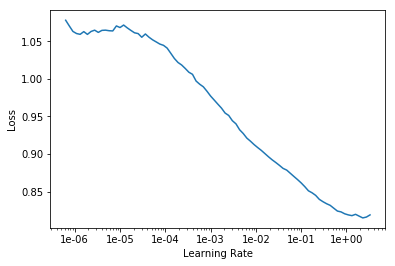

In [110]:
learn.lr_find()
learn.recorder.plot()

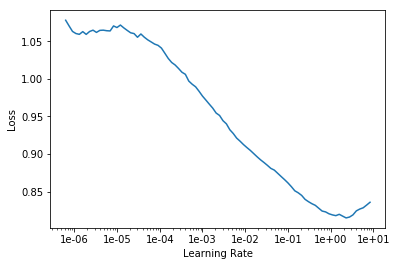

In [112]:
learn.recorder.plot(skip_end=0)

TODO: maybe don't do 1cycle?